# Environment

In [1]:
import os
import math

import numpy as np
import pandas as pd



from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

# DATA

## Data loading

In [2]:
#load data nhỏ
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  10.9M      0 --:--:-- --:--:-- --:--:--  278M


The dataset contains 1040 captcha files as `png` images. The label for each sample is a string,
the name of the file (minus the file extension).
We will map each character in the string to an integer for training the model. Similary,
we will need to map the predictions of the model back to strings. For this purpose
we will maintain two dictionaries, mapping characters to integers, and integers to characters,
respectively.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pwd

/content


In [5]:
!mkdir captcha113k

In [6]:
%cd captcha113k
!pwd

/content/captcha113k
/content/captcha113k


In [7]:
import gdown
url = 'https://drive.google.com/u/0/uc?id=1HupS43P60W1vzBxEvNMmKJubum9QqY_r&export=download'
output = '20150428_collected_images.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1HupS43P60W1vzBxEvNMmKJubum9QqY_r&export=download
To: /content/captcha113k/20150428_collected_images.zip
100%|██████████| 370M/370M [00:02<00:00, 169MB/s]


'20150428_collected_images.zip'

In [8]:
!pwd

/content/captcha113k


In [9]:
#load data lớn
!unzip /content/captcha113k/20150428_collected_images.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: data_v2/YPijd.jpg       
  inflating: data_v2/Ypik1.jpg       
  inflating: data_v2/ypikS.jpg       
  inflating: data_v2/Ypimj.jpg       
  inflating: data_v2/YPiNH.jpg       
  inflating: data_v2/YpiPj.jpg       
  inflating: data_v2/YPIVJ.jpg       
  inflating: data_v2/YPJ3E.jpg       
  inflating: data_v2/yPJi4.jpg       
  inflating: data_v2/yPJuY.jpg       
  inflating: data_v2/ypkED.jpg       
  inflating: data_v2/YPkMD.jpg       
  inflating: data_v2/YPKO6.jpg       
  inflating: data_v2/ypLCF.jpg       
  inflating: data_v2/Yplf4.jpg       
  inflating: data_v2/yplFR.jpg       
  inflating: data_v2/YPLgL.jpg       
  inflating: data_v2/YplYE.jpg       
  inflating: data_v2/ypmbZ.jpg       
  inflating: data_v2/YPMFn.jpg       
  inflating: data_v2/YPmkV.jpg       
  inflating: data_v2/YPMQF.jpg       
  inflating: data_v2/yPMY4.jpg       
  inflating: data_v2/YPnhR.jpg       
  inflating: data_v2/YPnP4.jpg 

In [10]:

# Path to the data directory
# data_dir = Path("/content/captcha_images_v2")
data_dir = Path("/content/captcha113k/data_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)#Set trong Python là tập hợp các phần tử duy nhất, không có thứ tự
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 64

# Desired image dimensions
img_width = 200
img_height = 50

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Preprocessing

In [11]:
X_train,X_val_test,y_train,y_val_test=train_test_split(images,labels,test_size=0.2,random_state=2023)
X_val,X_test,y_val,y_test=train_test_split(X_val_test,y_val_test,test_size=0.5,random_state=2023)

x_train=np.array(X_train)
x_val=np.array(X_val)
x_test=np.array(X_test)

y_train=np.array(y_train)
y_val=np.array(y_val)
y_test=np.array(y_test)

In [12]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)



def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    #print(img)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)#channels=1 để chuyển sang thang độ xám, để 3 nếu muốn nahr màu


    #print(img)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    #print(img)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    #print(img.shape)
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])# chuyển vị matrix hàng thành cột và cột thành hàng
    #print(img.shape)
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


## Create `Dataset` objects

In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

## Visualize the data

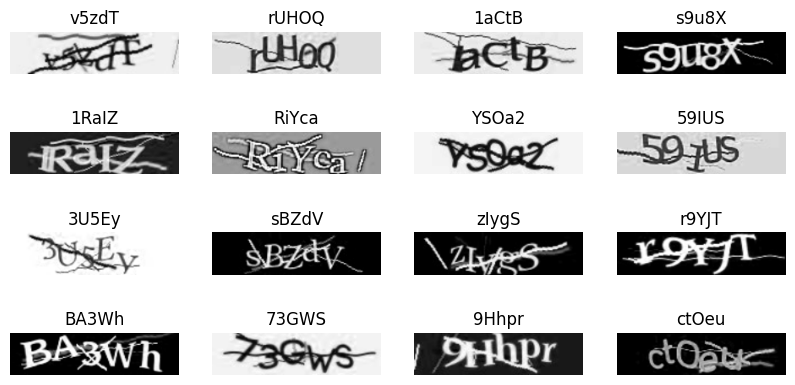

In [14]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

# MODEL

## Building


In [15]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

###Change CNN -> VGG16

In [16]:
from tensorflow.keras.applications.vgg16 import VGG16

# Tạo mô hình EfficientNet B0
model_test = VGG16(include_top=False,weights='imagenet',input_shape=(200,50,3))# input_shape thay đổi thì kiến trúc model cx thay đổi
model_test.summary()
# In thông tin về đầu vào của mô hình
print("Input shape:", model_test.input_shape)
print("Output shape:", model_test.output_shape)

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 50, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 50, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 50, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 25, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 25, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 25, 128)      147584    
                                                              

In [17]:
# model0 = VGG16(
#      include_top=False, weights="imagenet", input_shape=(200,50,3)
# )
# base_model=keras.models.Model(
#         model0.get_layer(name="input_2").input, model0.get_layer(name="block3_conv3").output
# )
# base_model.summary()

In [18]:
# base_model.output.shape

###Change CNN -> AlexNet

In [19]:
#Link: https://www.kaggle.com/code/vortexkol/alexnet-cnn-architecture-on-tensorflow-beginner
# keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(200,50,3)),

AlexNet = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(11,11), strides=(1,1), activation='relu', input_shape=(200,50,3), padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(3,3), padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), activation='relu', padding="same"),
    keras.layers.MaxPool2D(pool_size=(2,2), padding="same"),


], name="AlexNet")

In [20]:
AlexNet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 50, 64)       23296     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 67, 17, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 67, 17, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 6, 128)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 6, 128)        65664     
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 6, 128)        6566

In [21]:
AlexNet.output.shape

TensorShape([None, 12, 3, 128])

In [22]:

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 3), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Change CNN -> AlexNet
    load_model = AlexNet
    base_layer = load_model(input_img)
    #print(base_model_)

    output_shape = load_model.output.shape
    new_shape = (output_shape[1], output_shape[2]*output_shape[3])
    x = layers.Reshape(target_shape=new_shape, name="reshape")(base_layer)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)
    ##########

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    #print(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)# 50 vector (có len 21) phân phối xác suất thuộc về các lớp(20 lớp)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)# labels (5,);x(50,21)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )

    # for layer in base_model.layers:
    #   layer.trainable = False
    # Optimizer
    opt = keras.optimizers.Adam()#learning rate=0.001 default
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()
#NHÌN SUMMMARY ĐỂ HIỂU KIẾN TRÚC
#64*769=49216

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 AlexNet (Sequential)           (None, 12, 3, 128)   425216      ['image[0][0]']                  
                                                                                                  
 reshape (Reshape)              (None, 12, 384)      0           ['AlexNet[0][0]']                
                                                                                                  
 dense1 (Dense)                 (None, 12, 64)       24640       ['reshape[0][0]']     

## Training

In [23]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [24]:

epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)
# Train the model
history = model.fit(
    train_dataset,
    batch_size = 1,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)


Epoch 1/100
1414/1414 [==============================] - 170s 106ms/step - loss: 21.3124 - val_loss: 20.7632
Epoch 2/100
1414/1414 [==============================] - 134s 95ms/step - loss: 17.5253 - val_loss: 13.7364
Epoch 3/100
1414/1414 [==============================] - 138s 98ms/step - loss: 12.4849 - val_loss: 9.9030
Epoch 4/100
1414/1414 [==============================] - 140s 99ms/step - loss: 9.8935 - val_loss: 8.0749
Epoch 5/100
1414/1414 [==============================] - 136s 96ms/step - loss: 8.2722 - val_loss: 6.6073
Epoch 6/100
1414/1414 [==============================] - 136s 96ms/step - loss: 7.1853 - val_loss: 5.7360
Epoch 7/100
1414/1414 [==============================] - 137s 97ms/step - loss: 6.4403 - val_loss: 5.2043
Epoch 8/100
1414/1414 [==============================] - 138s 98ms/step - loss: 5.8658 - val_loss: 4.8439
Epoch 9/100
1414/1414 [==============================] - 137s 97ms/step - loss: 5.4358 - val_loss: 4.5405
Epoch 10/100
1414/1414 [================

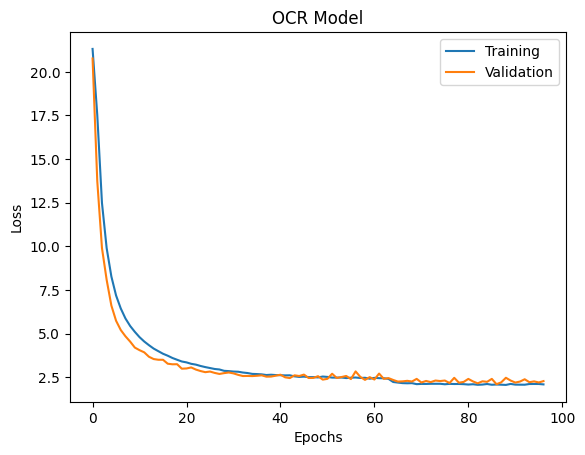

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('OCR Model')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [26]:
model.evaluate(validation_dataset)

177/177 [==============================] - 12s 68ms/step - loss: 2.0990


2.098991632461548

In [27]:
model.evaluate(test_dataset)

177/177 [==============================] - 12s 66ms/step - loss: 2.1330


2.1330387592315674

#Evaluation

In [35]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

#mới chỉ tính trên validation
preds = prediction_model.predict(test_dataset)
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text
pred_texts = decode_batch_predictions(preds)
print(pred_texts[0:5])
print(y_val[0:5])

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


177/177 [==============================] - 10s 42ms/step
['SZqp9', 'JUN5z', 'LwdCR', 'Q5byv', 'BZ5Z[UNK]']
['wGC8A' 'pJlha' 'AlgsR' 'geqBS' 'EFXCl']


In [37]:
y_true = y_test
correct_char = 0
total_char = 0
correct = 0
#xét từng cặp true,pred
# nếu true=pred thì số nhãn đoán đúng +1
# với mỗi kí tự trong true ss với kí tự trong pred ở vị trí tương ứng, nếu bằng số kí tự đúng +1
for i in range(len(y_true)):
    pr = pred_texts[i]
    tr = y_true[i]
    total_char += len(tr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))#nếu muốn tính % sai hãy dùng Edit distance
print('Correct words predicted      : %.2f%%' %(correct*100/len(y_true)))

Correct characters predicted : 84.92%
Correct words predicted      : 58.52%


# Inference

In [30]:
validation_dataset.take(1)

<_TakeDataset element_spec={'image': TensorSpec(shape=(None, 200, 50, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 3)]      0         
                                                                 
 AlexNet (Sequential)        (None, 12, 3, 128)        425216    
                                                                 
 reshape (Reshape)           (None, 12, 384)           0         
                                                                 
 dense1 (Dense)              (None, 12, 64)            24640     
                                                                 
 dropout (Dropout)           (None, 12, 64)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 12, 256)          197632    
 l)                                                              
                                                           

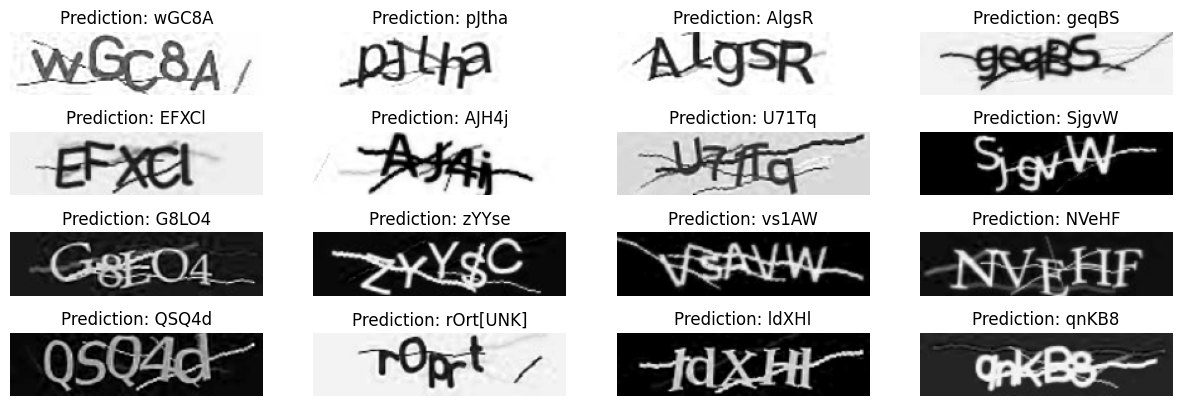

In [31]:

# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    print(batch_labels.shape)
    preds = prediction_model.predict(batch_images)
    print(preds.shape)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))# 4 hàng , 4 cột
    for i in range(len(pred_texts)):
      if i<16:# chỗ này có 16 ô để vẽ hình thôi nên để i>16 tức là vẽ nhiều hơn 16 hình thì lỗi
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i// 4, i % 4].imshow(img, cmap="gray")
        ax[i// 4, i % 4].set_title(title)
        ax[i// 4, i % 4].axis("off")
plt.show()

#Save model

In [32]:
prediction_model.save('ocr_model')

#Load Model

In [33]:
load_model_pred=tf.keras.saving.load_model("ocr_model")

2/2 [==============================] - 1s 10ms/step


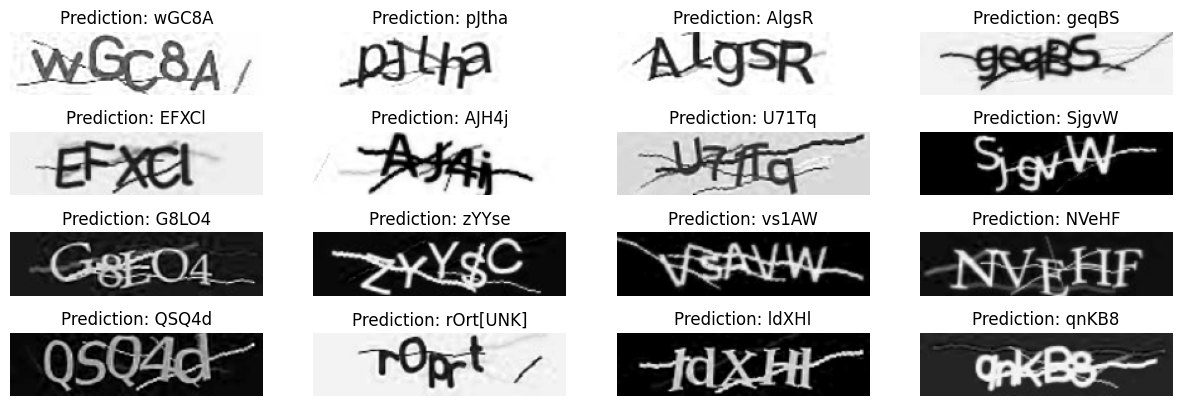

In [34]:
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = load_model_pred.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
      if i<16:
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()